# Asset Pricing - Final Project

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import yfinance as yf
from scipy.stats import f


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Ubuntu',
    'font.monospace': 'Ubuntu Mono',
    'font.size': 14,

    'axes.labelweight': 'normal',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlesize': 16,
    'axes.titlelocation': 'center',
    'axes.labelpad': 10,
    'axes.titleweight': 'bold',
    'axes.titlepad': 15,
    
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    
    'figure.titlesize': 18,
    'figure.figsize': (10, 6),
    'figure.autolayout': True,
    'figure.subplot.wspace': 0.25,
    'figure.subplot.wspace': 0.4,

    'lines.linewidth': 2
})

## Data Loading and Preprocessing

### Load Fama-French 3-Factor Model

In [3]:
daily_factors = pd.read_csv(
    'datasets/ff_3factor_daily.csv',
    skiprows=5,
    skipfooter=1,
    names=['date', 'mkt-rf', 'smb', 'hml', 'rf'],
    index_col=[0],
    parse_dates=[0],
    engine='python'
    )/100

monthly_factors = pd.read_csv(
    'datasets/ff_3factor_monthly.csv',
    skiprows=5,
    skipfooter=1,
    names=['date', 'mkt-rf', 'smb', 'hml', 'rf'],
    index_col=[0],
    parse_dates=[0],
    date_parser=lambda x: pd.to_datetime(x, format='%Y%m'),
    engine='python'
    )/100
monthly_factors.index = monthly_factors.index.to_period('M')

annual_factors = pd.read_csv(
    'datasets/ff_3factor_annual.csv',
    skiprows=5,
    skipfooter=1,
    names=['date', 'mkt-rf', 'smb', 'hml', 'rf'],
    index_col=[0],
    parse_dates=[0],
    engine='python'
    )/100
annual_factors.index = annual_factors.index.to_period('Y')

### Load US Stock Market Sector Indexes

In [4]:
indexes = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']
factors = ['mkt-rf', 'smb', 'hml']
start_date = "2004-01-01"
end_date = "2012-01-01"

# load index prices from yahoo finance
daily_prices = yf.download(
    indexes,
    start=start_date,
    end=end_date
    )['Close']
daily_prices.index.rename('date', inplace=True)

# calculate daily, monthly, and annual returns
daily_returns = daily_prices.pct_change().dropna()

monthly_returns = daily_prices.resample('MS').last().pct_change().dropna()
monthly_returns.index = monthly_returns.index.to_period('M')

annual_returns = daily_prices.resample('YS').last().pct_change().dropna()
annual_returns.index = annual_returns.index.to_period('A')

[*********************100%***********************]  9 of 9 completed


### Merge dataframes and subtract $R_f$ from index returns

In [5]:
# merge daily factors and index returns
df_daily = pd.merge(
    daily_factors, daily_returns,
    left_index=True, right_index=True,
    how='inner'
    )

# merge monthly factors and index returns
df_monthly = pd.merge(
    monthly_factors, monthly_returns,
    left_index=True, right_index=True,
    how='inner'
    )

# merge annual factors and index returns
df_annual = pd.merge(
    annual_factors, annual_returns,
    left_index=True, right_index=True,
    how='inner'
    )

# subtract risk free rate from index returns
for index in indexes: 
    df_daily[index] = df_daily[index] - df_daily['rf']
    df_monthly[index] = df_monthly[index] - df_monthly['rf']
    df_annual[index] = df_annual[index] - df_annual['rf']

## Visualizing daily data correlations

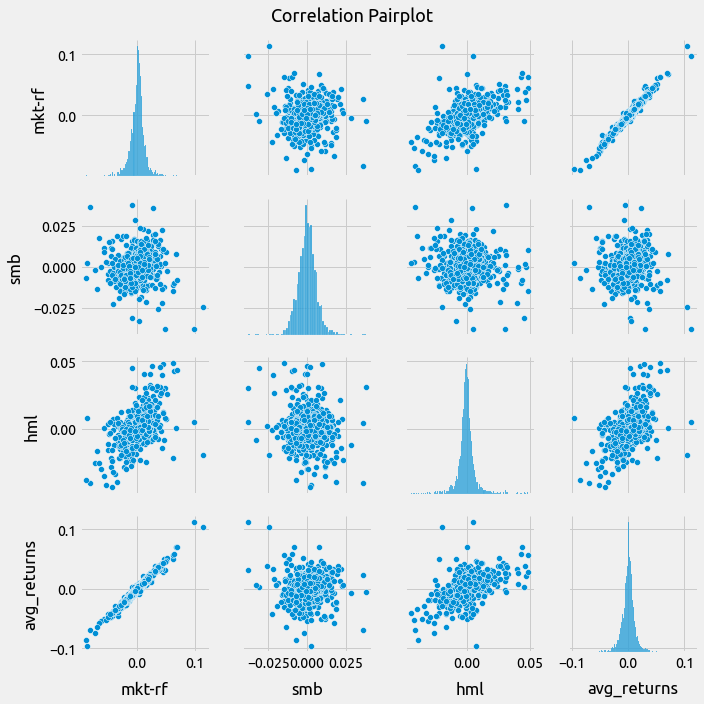

In [6]:
df_plot = df_daily[factors].copy()
df_plot.loc[:, 'avg_returns'] = df_daily[indexes].mean(axis=1)

ax = sns.pairplot(df_plot)
ax.fig.suptitle('Correlation Pairplot')
plt.show()

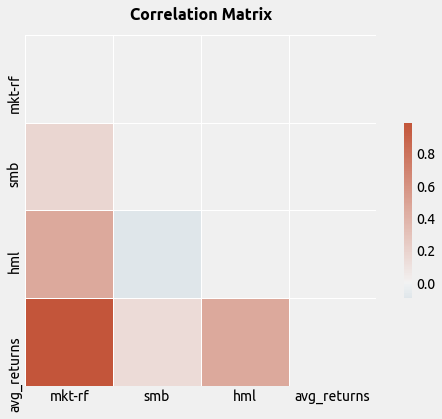

In [7]:
f, ax = plt.subplots(figsize=(8, 6))

corr = df_plot.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=.5, 
    cbar_kws={"shrink": .5}
    )

plt.title('Correlation Matrix')
plt.show()

## Testing the 3-Factor Model - Pre-Post 2008 Crisis

#### Full-period: Check for sensibilities in data with different frequencies

In [8]:
iterables = [indexes, ['const'] + factors + ['R_squared']]
index = pd.MultiIndex.from_product(iterables, names=["name", "feature"])

iterables = [['daily', 'monthly', 'annual'], ['value', 'std_error', 't_value', 'p_value']]
column = pd.MultiIndex.from_product(iterables)

results = pd.DataFrame(index=index, columns=column)

##### Daily

In [9]:
X = sm.add_constant(df_daily[factors])

for index in indexes:
    y = df_daily[index]

    model = sm.OLS(y, X)
    res = model.fit()

    for feature in ['const'] + factors:
        results.loc[(index, feature), ('daily', 'value')] = res.params[feature]
        results.loc[(index, feature), ('daily', 'std_error')] = res.bse[feature]
        results.loc[(index, feature), ('daily', 't_value')] = res.tvalues[feature]
        results.loc[(index, feature), ('daily', 'p_value')] = res.pvalues[feature]

    results.loc[(index, 'R_squared'), ('daily', 'value')] = res.rsquared

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


##### Monthly

In [10]:
X = sm.add_constant(df_monthly[factors])

for index in indexes:
    y = df_monthly[index]

    model = sm.OLS(y, X)
    res = model.fit()
    
    for feature in ['const'] + factors:
        results.loc[(index, feature), ('monthly', 'value')] = res.params[feature]
        results.loc[(index, feature), ('monthly', 'std_error')] = res.bse[feature]
        results.loc[(index, feature), ('monthly', 't_value')] = res.tvalues[feature]
        results.loc[(index, feature), ('monthly', 'p_value')] = res.pvalues[feature]

    results.loc[(index, 'R_squared'), ('monthly', 'value')] = res.rsquared

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


##### Annual

In [11]:
X = sm.add_constant(df_annual[factors])

for index in indexes:
    y = df_annual[index]

    model = sm.OLS(y, X)
    res = model.fit()
    
    for feature in ['const'] + factors:
        results.loc[(index, feature), ('annual', 'value')] = res.params[feature]
        results.loc[(index, feature), ('annual', 'std_error')] = res.bse[feature]
        results.loc[(index, feature), ('annual', 't_value')] = res.tvalues[feature]
        results.loc[(index, feature), ('annual', 'p_value')] = res.pvalues[feature]

    results.loc[(index, 'R_squared'), ('annual', 'value')] = res.rsquared

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
results.to_csv('results/full_period_results.csv')

#### Analysing structural breaks using daily data

##### Financial Index

In [48]:
break_date = '2008-09-15'

# full period
X = sm.add_constant(df_daily[factors])
y = df_daily[['XLF']]
model = sm.OLS(y, X)
res = model.fit()

# pre 2008
X_pre = sm.add_constant(df_daily[:break_date].iloc[:-1][factors])
y_pre = df_daily[:break_date].iloc[:-1]['XLF']
model = sm.OLS(y_pre, X_pre)
res_pre = model.fit()

# post 2008
X_post = sm.add_constant(df_daily[break_date:][factors])
y_post = df_daily[break_date:]['XLF']
model = sm.OLS(y_post, X_post)
res_post = model.fit()

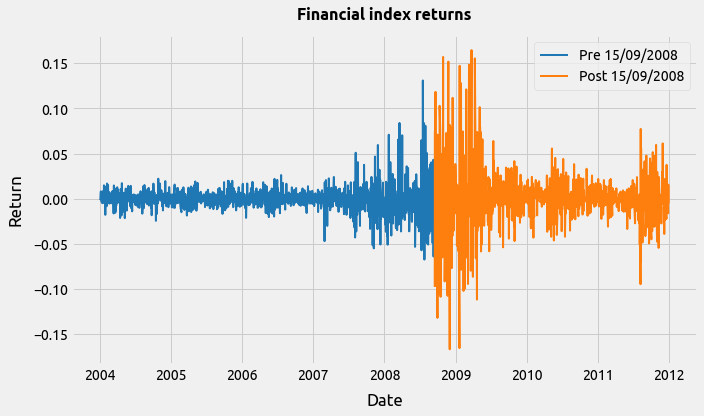

In [52]:
plt.figure()
plt.title('Financial index returns')
plt.ylabel('Return')
plt.xlabel('Date')
plt.plot(y_pre.index, y_pre, c='tab:blue')
plt.plot(y_post.index, y_post, c='tab:orange')
plt.legend(['Pre 15/09/2008', 'Post 15/09/2008'])
plt.show()

In [49]:
### perform a chow test

# sum of squared residuals for different periods
SSR = res.ssr
SSR1 = res_pre.ssr
SSR2 = res_post.ssr

k = X.shape[1] # number of explanatory variables
n = len(X_pre) + len(X_post) # number of samples

F = ((SSR - SSR1 - SSR2)/k)/((SSR1 + SSR2)/(n - 2*k))
print('Chow test F-value:', round(F,4))

F_critical = f.ppf(0.95, k, n-2*k)
print('critical f-value:', round(F_critical, 4))

p_value = 1 - f.cdf(F, k, n-2*k)
print('p-value:', round(p_value, 4))

Chow test F-value: 23.289
critical f-value: 2.3764
p-value: 0.0


We can see that the p-value is below 5%, and, therefore, we reject the null hypothesis that there's no improvement in fit by splitting the data and fitting each subsample individually. This indicates that the model for the full data is not stable throughout time.